# Generate Additional Results (as per Feedback)

In [5]:
items = [
    'bag',
    'belt',
    'blazer',
    'blouse',
    'bodysuit',
    'boots',
    'bra',
    'bracelet',
    'cape',
    'cardigan',
    'clogs',
    'coat',
    'dress',
    'earrings',
    'flats',
    'glasses',
    'gloves',
    'hat',
    'heels',
    'hoodie',
    'intimate',
    'jacket',
    'jeans',
    'jumper',
    'leggings',
    'loafers',
    'necklace',
    'panties',
    'pants',
    'pumps',
    'purse',
    'ring',
    'romper',
    'sandals',
    'scarf',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    'sneakers',
    'socks',
    'stockings',
    'suit',
    'sunglasses',
    'sweater',
    'sweatshirt',
    'swimwear',
    't-shirt',
    'tie',
    'tights',
    'top',
    'vest',
    'wallet',
    'watch',
    'wedges'
]

colors = [
    "black",
    "silver",
    "gray",
    "white",
    "maroon",
    "red",
    "purple",
    "fuchsia",
    "green",
    "lime",
    "olive",
    "yellow",
    "navy",
    "blue",
    "teal",
    "aqua",
    "brown",
    "orange",
]

## Query RTT experiment and results

In [19]:
import requests

RAINFOREST_API_KEY = '7747CDF0792A42C4A8702BF8F3EF7F51' #'48111ACC9B2F4AC7B834D95B53D88BAF'#'AA29B5C34DDF4513BCA018F896C3C62D'

def best_amazon_product(search_term, n=1):
    url = 'https://api.rainforestapi.com/request'
    params = {
        'api_key': RAINFOREST_API_KEY,
        'type': 'search',
        'amazon_domain': 'amazon.com',
        'search_term': search_term,
        'max_page': n,
    }
    return requests.get(url, params=params)

In [24]:
import time
import random

sweep, num_exp = 10, 10

rtt = dict()
for n in range(1, sweep+1):
    rtt[n] = []
    for m in range(num_exp):
        search_term = random.choice(colors) + ' ' + random.choice(items)

        start = time.time()
        response = best_amazon_product(search_term, n=n)
        end = time.time()

        if response.ok:
            rtt[n].append(end - start)

In [28]:
import json

with open('rtt.json', 'w') as fp:
    json.dump(rtt, fp)

with open('rtt.json', 'r') as fp:
    data = json.load(fp)

In [42]:
import numpy as np

counter = 0
for i in range(1, 4+1):
    if len(rtt[i]):
        counter += 1
    print(len(rtt[i]))

10
10
10
8


In [52]:
low = [np.percentile(x, 2.5) for _, x in rtt.items() if len(x) > 0]
high = [np.percentile(x, 97.5) for _, x in rtt.items() if len(x) > 0]
med = [np.percentile(x, 50) for _, x in rtt.items() if len(x) > 0]
avg = [np.mean(x) for _, x in rtt.items() if len(x) > 0]

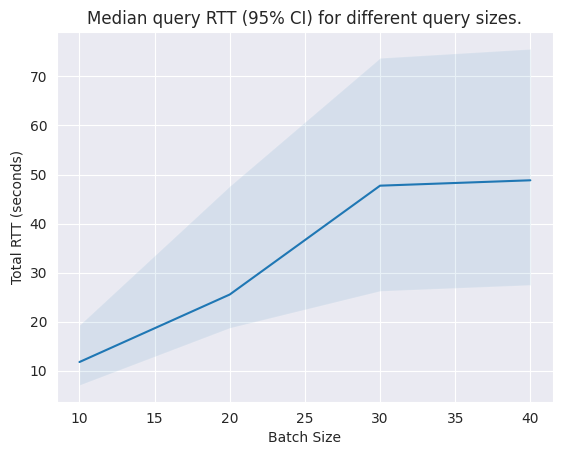

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure()
x = ((np.arange(counter)+1)*10).astype(int)
plt.plot(x, med)
plt.fill_between(x, low, high, alpha = 0.1)
plt.xlabel("Batch Size")
plt.ylabel("Total RTT (seconds)")
plt.title("Median query RTT (95% CI) for different query sizes.")
fig.savefig(f"rtt.pdf", format="pdf", dpi=1200)
fig.savefig(f"rtt.png", format="png", dpi=1200)

## Cache Hit vs Miss latency results

In [117]:
all_rtt = [
    18.0866,
    0.328359,
    14.5504,
    0.325535,
    15.1205,
    0.523358,
    8.86853,
    0.339202,
    21.3126,
    0.327412,
    18.5526,
    0.333055,
    14.8104,
    0.416328,
    12.4755,
    0.522981,
    10.8713,
    0.367397,
    18.6033,
    0.861236,
    13.4894,
]
rtt_data = {"Cache Hit":[], "Cache Miss":[]}
while all_rtt:
    rtt_data["Cache Miss"].append(all_rtt.pop())
    if all_rtt:
        rtt_data["Cache Hit"].append(all_rtt.pop())
rtt_data

{'Cache Hit': [0.861236,
  0.367397,
  0.522981,
  0.416328,
  0.333055,
  0.327412,
  0.339202,
  0.523358,
  0.325535,
  0.328359],
 'Cache Miss': [13.4894,
  18.6033,
  10.8713,
  12.4755,
  14.8104,
  18.5526,
  21.3126,
  8.86853,
  15.1205,
  14.5504,
  18.0866]}

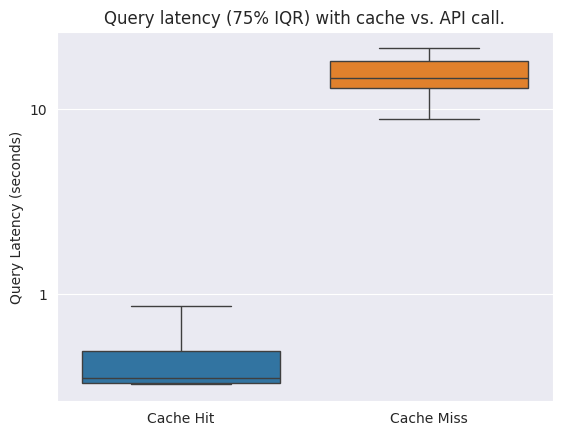

In [127]:
fig = plt.figure()
ax=sns.boxplot(rtt_data, log_scale=True)
# plt.xlabel("Batch Size")
def format_func(value, tick_number):
    return '%g' % (value)
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
plt.ylabel("Query Latency (seconds)")
plt.title("Query latency (75% IQR) with cache vs. API call.")
fig.savefig(f"cache.pdf", format="pdf", dpi=1200)
fig.savefig(f"cache.png", format="png", dpi=1200)

## Recommendation Accuracy Results

In [121]:
# this data was geenrated as a result of our recommendation accuracy experiment
data = {
    "Rating/Price": [1]*19 + [0]*11,
    "Price$^{-1}$": [1]*4 + [0]*26,
    "Random": [1]*9 + [0]*21,
}

def accuracy(data):
    return np.mean(data)*100.0

def bootstrap(data, n=1000):
    bootstrapped_data = []
    for _ in range(n):
        sample = random.choices(data, k=len(data))
        bootstrapped_data.append(accuracy(sample))
    return bootstrapped_data

bootstrapped_data = {
    k: bootstrap(v) for k, v in data.items()
}

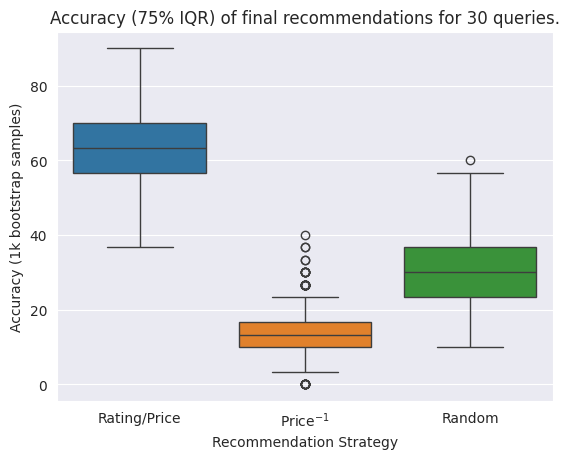

In [122]:
fig = plt.figure()
sns.boxplot(bootstrapped_data)
plt.ylabel("Accuracy (1k bootstrap samples)")
plt.xlabel("Recommendation Strategy")
plt.title("Accuracy (75% IQR) of final recommendations for 30 queries.")
fig.savefig(f"rec_comp.pdf", format="pdf", dpi=1200)
fig.savefig(f"rec_comp.png", format="png", dpi=1200)